In [182]:
import pandas as pd
import scipy as sp
from scipy.sparse import diags
import numpy as np
from numpy import linalg as LA
import sys
from os import path

import matplotlib.pyplot as plt

#importing seaborn for plotting
import seaborn as sns

#for plotting purposes
%pylab inline
sns.set_style('ticks')
sns.set_context('paper')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib as mpl

# mpl.rcParams
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = [8, 16/3]

Populating the interactive namespace from numpy and matplotlib


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['subtract', 'time', 'sample', 'trace']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## functions for use in processing

In [183]:
#porting from HITRACE
#based on Baseline correction for NMR spectroscopic metabolomics data analysis. 2008, 
#Author(s): Xi, Yuanxin and Rocke, David M
#https://doi.org/10.1186/1471-2105-9-324 and further modified by Rhiju (Stanford University)
#name of variables tracks closely to what is presented in the manuscript

def baseline_xi(b,A=2e9,B=2e4,s=1.0):
    # Input: 
    # b Nx1, spectrum data
    # A 1x1 smoothing factor
    # B 1x1 negative penalty
    # s 1x1 noise standard deviation

    # Output:
    # bd Nx1 baseline
    # b_subtract Nx1 background subtracted trace

    L = len(b)

    # b is the SIGNAL (gamma in the paper). bd is the estimated baseline (b in the paper).
    bd = np.ones((L,1))*np.median(b)
    bd0 = b

    #current error
    nm = LA.norm(b-bd0)
    nm0 = sys.float_info.max #initialize with largest possible float

    #solving D*bd = m
    #D and m have been divided through by A
    #Mistake in expression for M; should be +1, not -1
    M0 = s*np.ones((L,1))/A

    #initialize D matrix
    e = np.ones((L,1))
    diagonals = [2, -8, 12, -8, 2]
    D0 = diags(diagonals, np.arange(-2,3), shape=(L,L)).toarray()
    
    D0[0,0] = 2
    D0[L-1,L-1] = 2

    D0[1,0] = -4
    D0[0,1] = -4
    D0[L-1,L-2] = -4
    D0[L-2,L-1]= -4

    D0[1,1] = 10
    D0[L-2,L-2] = 10

    #index for iteration
    i=0

    while ((nm>10 or i<5) and i<30):
        i=i+1
        M = M0
        D = D0
        bd0 = bd
        nm0=nm #not sure this is needed, nm0 not used in iteration

        for j in np.arange(0,L):
            if (bd[j]>b[j]):
                M[j] = M[j] + 2*(B/A)*b[j]
                D[j,j] = D[j,j] + 2*(B/A)

        bd = solve(D,M).flatten() #need to flatten to convert to 1D array
        nm = LA.norm(bd0-bd)
    
    b_subtract = b-bd
    return b_subtract,bd

#### functions for finding peaks and calculating areas

In [184]:
from scipy.signal import find_peaks

###returns indices for peaks for a given trace as well as the values at the peaks
def find_trace_peaks(trace, min_distance=100, min_height=2.5):
    
    peak_idx, _ = find_peaks(trace, distance=min_distance, height=min_height)  
    peak_val = trace[peak_idx]

    return peak_idx, peak_val

In [185]:
def return_peak_areas(start_nt, end_nt, trace, trace_nt, ctrl_start=200, ctrl_end = 300):
    #start_nt and end_nt should flank the peak of interest
    #trace refers to the reading values (FU on the Bioanalyzer)
    #trace_nt refers to the x-axis, or the nucleotides corresponding to different values in trace
    #ctrl_start, and ctrl_end refer to P4P6 control, and is flanking a wider nucleotide window to account for accumulation
    #of background, degraded RNAs
    
    #indices for P4P6
    p4p6_start_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-ctrl_start))
    p4p6_end_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-ctrl_end))

    #indices for mRNA
    first_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-start_nt))
    last_idx = min(range(len(nts)), key=lambda i: abs(nts[i]-end_nt)) 
    
    #calculating areas
    p4p6_area = np.trapz(y=trace[p4p6_start_idx:p4p6_end_idx], x=nts[p4p6_start_idx:p4p6_end_idx])
    background_area = np.trapz(y=[trace[first_idx], trace[last_idx]], x=[nts[first_idx],nts[last_idx]])
    total_area = np.trapz(y=trace[first_idx:last_idx], x=nts[first_idx:last_idx])
    
    subtracted_area = total_area-background_area
    normalized_area = subtracted_area/p4p6_area
    
    return p4p6_area, background_area, total_area, subtracted_area, normalized_area


def calc_frac_intact(times, norm_areas):
    
    init_val = float(norm_areas[0])
    frac_intact = (norm_areas/init_val).clip(0)
    
    return frac_intact

In [186]:
from scipy.optimize import curve_fit

#returns indices, bootstrapped
def bootstrap_inds(x):
    bs_indices = np.random.choice(range(len(x)),len(x))
    return bs_indices

#function for exponential fitting
def func(x, b):
    return np.exp(-b*x)


def exp_fit(frac_intact, timepoints, func, bs_iter = 1000):
    fit_coeffs = []
    for i in np.arange(0,bs_iter,1):
        
        #just in case
        frac_intact = np.clip(a=frac_intact, a_min=0, a_max=max(frac_intact))
        
        #generate bootstrap indices
        bs_indices = bootstrap_inds(frac_intact)
        
        #generating data for fit
        fit_t = [timepoints[i] for i in bs_indices]
        fit_fracint = [frac_intact[i] for i in bs_indices]
        
        #exponential fit
        popt, pcov = curve_fit(func, fit_t, fit_fracint)
        
        fit_coeffs.append(popt[0])
    
    return fit_coeffs

# Analysis of samples starts here:

### appending file names from each sample

In [187]:
### read in sample map
map_df = pd.read_csv('sample_nucleotide_filename.csv')
# map_df

#match plate number to filename:
filenames_df = pd.read_csv('platenumber_filename.csv')
# filenames_df
filenames_dict = dict(zip(filenames_df['Plate_Number'],filenames_df['File_Name']))
# filenames_dict


data_dir = './processed_data/'
#mapping plate number to filename, adding column to map
filenames = []

for filename, filenum in zip(map_df['Plate'], map_df['FileNumber']):
    name = filenames_dict[filename]
    name = 'nts-'+name+'_Sample'+str(filenum)+'.csv'
#     print(name)
    filenames.append(name)

"""
check that files exist
commented out for now after checking, we're good
"""
# for filename in filenames:
#     print(path.exists(data_dir+filename))

map_df['FileName'] = filenames
# map_df

"\ncheck that files exist\ncommented out for now after checking, we're good\n"

In [188]:
peak_nts_list = []
start_nt_list = []
end_nt_list = []
p4p6_area_list = []
bg_area_list = []
total_area_list = []
subtract_area_list = []
normalized_area_list = []
signal_normalized_area_list = []

plot_dir = './plots/'

peaks_nt_dict = {}
# Iterate through the list of samples, and return a df that has nucleotides and background subtracted values
for row in map_df.itertuples():
    clf()
    #read in dataframe for given sample
    sample_df = pd.read_csv(data_dir+row.FileName)
    
    #extract time series and nucleotides, let's clip to just the first third (up to ~1400 nucleotides)
    array_len = len(sample_df['Nucleotides'])
    clip_len = int(array_len/2.2)
    
    nts = np.array(sample_df['Nucleotides'][:clip_len])
    trace = np.array(sample_df['Value'][:clip_len])
    
    plot(nts, trace, label=row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    title(row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    xlabel('Nucleotides')
    ylabel('Signal (FU)')
    tight_layout()
    
    savefig(plot_dir+row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint)+'.png', dpi=300)
    clf()
    
    ###plotting the background subtracted trace
    trace_norm,_ = baseline_xi(trace)
    plot(nts, trace_norm, label=row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    title(row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint))
    xlabel('Nucleotides')
    ylabel('Signal (FU)')
    tight_layout()
    
    savefig(plot_dir+'normalized-'+row.Sample+'_'+row.Nucleotide+'_'+str(row.Timepoint)+'.png', dpi=300)
    clf()
    
    
    if (row.Timepoint == 0):
        peak_idx, peak_val = find_trace_peaks(trace,min_distance=100, min_height=1)
        peak_nts = nts[peak_idx]
        peak_nts_list.append(peak_nts)
        
        start_nt = nts[peak_idx][-1]-100
        end_nt = nts[peak_idx][-1]+100
        
        start_nt_list.append(start_nt)
        end_nt_list.append(end_nt)
        
        peak_assign_dict = {}
        peak_assign_dict['start_nt'] = start_nt
        peak_assign_dict['end_nt'] = end_nt
        peak_assign_dict['peaks'] = peak_nts
        
        peaks_nt_dict[(row.Sample, row.Nucleotide)] = peak_assign_dict

    else:
        time_0_dict = peaks_nt_dict[(row.Sample, row.Nucleotide)]
        peak_nts_list.append(time_0_dict['peaks'])
        start_nt_list.append(time_0_dict['start_nt'])
        end_nt_list.append(time_0_dict['end_nt'])
        
        start_nt = time_0_dict['start_nt']
        end_nt = time_0_dict['end_nt']


#     #integrate at specified nucleotides per sample
#     start_nt = nts[peak_idx][-1]-100
#     end_nt = nts[peak_idx][-1]+100
#     start_nt_list.append(start_nt)
#     end_nt_list.append(end_nt)
    
    p4p6, background, total, subtract, normalized = return_peak_areas(start_nt, end_nt, trace, nts)
    p4p6_area_list.append(p4p6)
    bg_area_list.append(background)
    total_area_list.append(total)
    subtract_area_list.append(subtract)
    normalized_area_list.append(normalized)
    
    _,_,control_area_25, _, _ = return_peak_areas(start_nt=5, end_nt = 50, trace=trace, trace_nt=nts)
    double_normalized = normalized/control_area_25
    signal_normalized_area_list.append(double_normalized)

map_df = map_df.assign(peak_nts = peak_nts_list, start_nt = start_nt_list, end_nt = end_nt_list,\
              p4p6_area = p4p6_area_list, background_area = bg_area_list, total_area = total_area_list,\
              subtracted_area = subtract_area_list, normalized_area = normalized_area_list, double_normalized = signal_normalized_area_list)

map_df
#export dataframe to .csv for recordkeeping
map_df.to_csv('11-30-2020_analyzed_samples_doublenormalized.csv')

#plot configuration
# title('Background Subtracted Traces')
# xlabel('Nucleotides')
# ylabel('Signal (FU)')
# tight_layout()
# savefig('10-21-2020_traces.png', dpi=300)

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LinearDesign-1_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Nluc-start_hHBB_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LinearDesign-1_SINV_URE_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_PSU_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_PSU_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_PSU_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Nluc_start_SINV_URE_PSU_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Yellowstone_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Yellowstone_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Yellowstone_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Yellowstone_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Yellowstone_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Yellowstone_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Yellowstone_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Yellowstone_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Curevac_2_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Curevac_2_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Curevac_2_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Curevac_2_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Curevac_2_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Curevac_2_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Curevac_2_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_Curevac_2_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LocalDesign_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LocalDesign_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LocalDesign_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LocalDesign_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LocalDesign_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LocalDesign_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LocalDesign_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_LocalDesign_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_-423.7 kCal_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_-423.7 kCal_hHBB_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_-423.7 kCal_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_-423.7 kCal_hHBB_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_-423.7 kCal_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_-423.7 kCal_hHBB_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_-423.7 kCal_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'hHBB_-423.7 kCal_hHBB_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Yellowstone_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Yellowstone_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Yellowstone_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Yellowstone_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Yellowstone_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Yellowstone_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Yellowstone_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Yellowstone_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Curevac_2_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Curevac_2_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Curevac_2_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Curevac_2_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Curevac_2_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Curevac_2_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Curevac_2_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_Curevac_2_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LocalDesign_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LocalDesign_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LocalDesign_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LocalDesign_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LocalDesign_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LocalDesign_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LocalDesign_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_LocalDesign_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_-423.7 kCal_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_-423.7 kCal_SINV_URE_natural_0')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_-423.7 kCal_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_-423.7 kCal_SINV_URE_natural_1')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_-423.7 kCal_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_-423.7 kCal_SINV_URE_natural_3')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_-423.7 kCal_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

Text(0.5, 1.0, 'C3_-423.7 kCal_SINV_URE_natural_5')

Text(0.5, 0, 'Nucleotides')

Text(0, 0.5, 'Signal (FU)')

,Sample,Nucleotide,Timepoint,Plate,FileNumber,FileName,peak_nts,start_nt,end_nt,p4p6_area,background_area,total_area,subtracted_area,normalized_area,double_normalized
0,hHBB_LinearDesign-1_hHBB,natural,0,1,2,nts-Eukaryote Total RNA Nano_2020-11-24_11-30-...,"[23.659708709220236, 276.5198681311367, 906.93...",806.931045,1006.931045,157.750573,521.559134,2368.497254,1846.938120,11.707965,0.174939
1,hHBB_LinearDesign-1_hHBB,natural,1,1,4,nts-Eukaryote Total RNA Nano_2020-11-24_11-30-...,"[23.659708709220236, 276.5198681311367, 906.93...",806.931045,1006.931045,229.676380,748.641526,2284.139587,1535.498061,6.685485,0.108871
2,hHBB_LinearDesign-1_hHBB,natural,3,1,5,nts-Eukaryote Total RNA Nano_2020-11-24_11-30-...,"[23.659708709220236, 276.5198681311367, 906.93...",806.931045,1006.931045,221.568048,762.766334,1639.882693,877.116359,3.958677,0.062640
3,hHBB_LinearDesign-1_hHBB,natural,5,1,6,nts-Eukaryote Total RNA Nano_2020-11-24_11-30-...,"[23.659708709220236, 276.5198681311367, 906.93...",806.931045,1006.931045,221.209442,768.203580,1520.740328,752.536748,3.401920,0.058946
4,hHBB_LinearDesign-1_hHBB,PSU,0,1,7,nts-Eukaryote Total RNA Nano_2020-11-24_11-30-...,"[23.659708709220236, 276.5198681311367, 886.81...",786.816025,986.816025,145.518167,318.025953,2223.894491,1905.868538,13.097118,0.254244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,C3_LocalDesign_SINV_URE,natural,5,10,8,nts-Eukaryote Total RNA Nano_2020-11-24_13-37-...,"[23.290137739213147, 278.06831580626704, 806.7...",706.747007,906.747007,437.539880,244.456530,239.194128,-5.262402,-0.012027,-0.000121
92,C3_-423.7 kCal_SINV_URE,natural,0,10,9,nts-Eukaryote Total RNA Nano_2020-11-24_13-37-...,"[23.290137739213147, 275.2846468710941, 806.74...",706.747007,906.747007,177.047648,286.746630,2555.643746,2268.897116,12.815178,0.128556
93,C3_-423.7 kCal_SINV_URE,natural,1,10,10,nts-Eukaryote Total RNA Nano_2020-11-24_13-37-...,"[23.290137739213147, 275.2846468710941, 806.74...",706.747007,906.747007,310.985167,469.494179,1230.701364,761.207185,2.447728,0.024934
94,C3_-423.7 kCal_SINV_URE,natural,3,10,11,nts-Eukaryote Total RNA Nano_2020-11-24_13-37-...,"[23.290137739213147, 275.2846468710941, 806.74...",706.747007,906.747007,280.995834,344.585497,460.823825,116.238329,0.413666,0.004326


<Figure size 576x384 with 0 Axes>

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('C3_-423.7 kCal_SINV_URE', 'natural')
1.4827038986804886
0.22400234630291066


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Trying an exponential fit...('C3_Curevac_2_SINV_URE', 'natural')
1.0240038319799187
0.04188542965997269


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('C3_LinearDesign-1_SINV_URE', 'PSU')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.31299448696569193
0.12337132250775036


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('C3_LinearDesign-1_SINV_URE', 'natural')
0.5276126484188921
0.09968884050425478


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('C3_LocalDesign_SINV_URE', 'natural')
Could not converge for...('C3_LocalDesign_SINV_URE', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('C3_Nluc_start_SINV_URE', 'PSU')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.7801785379746472
0.10273086599833715


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('C3_Nluc_start_SINV_URE', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


2.3165796200882736
0.3627901314089564


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('C3_Yellowstone_SINV_URE', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.207177460944652
0.0679326604621402


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2', 'natural')
Could not converge for...('CoV-2-TTG-TTGfull-dSL1-3_-423.7 kCal_DEN2', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2', 'natural')
Could not converge for...('CoV-2-TTG-TTGfull-dSL1-3_Curevac_2_DEN2', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2', 'PSU')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.7931429933953752
0.08011614954159618


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('CoV-2-TTG-TTGfull-dSL1-3_LinearDesign-1_DEN2', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.082715727462828
0.10813293238156446


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('CoV-2-TTG-TTGfull-dSL1-3_LocalDesign_DEN2', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.6207618548177805
0.18446670974371462


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2', 'PSU')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.5899386077750686
0.2845006130637621


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2', 'natural')
Could not converge for...('CoV-2-TTG-TTGfull-dSL1-3_Nluc_start_DEN2', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2', 'natural')
Could not converge for...('CoV-2-TTG-TTGfull-dSL1-3_Yellowstone_DEN2', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_-423.7 kCal_hHBB', 'natural')
1.0534611964081142
0.13760569201956677


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_Curevac_2_hHBB', 'natural')
1.2869912343718788

/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)



0.27345464979262185


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_LinearDesign-1_hHBB', 'PSU')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.12944081994633896
0.1005704923144672


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_LinearDesign-1_hHBB', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.320949338867483
0.07868290753132633


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_LocalDesign_hHBB', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0.849157819740974
0.06715437794365242


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_Nluc-start_hHBB', 'PSU')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.0523808568404012
0.15959893266909095


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_Nluc-start_hHBB', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.9487343785433073
0.33322633918015543


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trying an exponential fit...('hHBB_Yellowstone_hHBB', 'natural')


/Users/dosoonkim/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


1.8072146787628558
0.39556141901090947


Text(0.5, 1.0, 'Fraction Intact')

Text(0.5, 0, 'Time (hours)')

Text(0, 0.5, 'Fraction Intact')

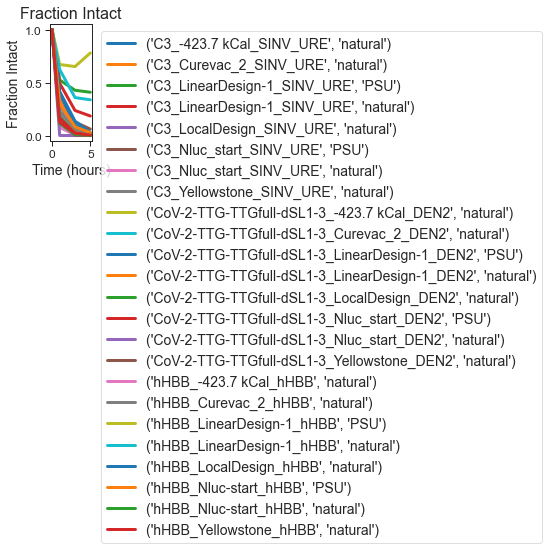

In [252]:
#all combinations of sample and nucleotide type
samples = set(zip(map_df['Sample'], map_df['Nucleotide']))

sample_dfs = []
sample_fits = {}
all_fits = {}
for sample in sorted(samples):
    rna_sample = sample[0]
    nucleotide = sample[1]

    working_df = map_df[(map_df['Sample']==rna_sample) & (map_df['Nucleotide']==nucleotide)]
#     working_df
    
#     norm_areas = np.array(working_df['normalized_area'])
    norm_areas = np.array(working_df['double_normalized'])
    times = np.array(working_df['Timepoint'])
    
    frac_intact = calc_frac_intact(times, norm_areas)
    working_df['Frac_Intact'] = frac_intact
    
    plot(times, frac_intact, label=sample, linewidth=3)
    
    fit_dict = {}
    
    try:
        print('Trying an exponential fit...'+str(sample))
        fits = exp_fit(timepoints=times, frac_intact=frac_intact, func=func)
        kdeg = np.mean(fits)
        kdeg_err = np.std(fits)
        print(kdeg)
        print(kdeg_err)
        fit_dict['kdeg'] = kdeg
        fit_dict['kdeg_err'] = kdeg_err
    except RuntimeError:
        print('Could not converge for...'+str(sample))
        fit_dict['kdeg'] = 'Error'
        fit_dict['kdeg_err'] = 'Error'
        continue
    
    sample_fits[sample] = fit_dict
    all_fits[sample] = fits
# sample_fits
legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
title('Fraction Intact')
xlabel('Time (hours)')
ylabel('Fraction Intact')

tight_layout()

In [253]:
fit_df = pd.DataFrame.from_dict(sample_fits, orient='index')
fit_df.to_csv('11-30-2020_exponential_fits.csv')

In [191]:
init_areas = {}
for sample in samples:
    sample_name = sample[0]
    sample_nt = sample[1]
    init_areas[sample] = float(map_df[(map_df['Timepoint']==0)&(map_df['Sample']==sample_name)
                               &(map_df['Nucleotide']==sample_nt)]['double_normalized'])

frac_intact_list = []
for row in map_df.itertuples():
    sample_nt = (row.Sample, row.Nucleotide)
    frac_intact = row.double_normalized/init_areas[sample_nt]
    frac_intact_list.append(frac_intact)

map_df['Fraction_intact'] = frac_intact_list

map_df.to_csv('11-30-2020_fraction_intact.csv')

### comparing natural RNAs only
#### barplot, fraction intact over 4 time points

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Natural nucleotide, Fraction intact over time')

Text(0.5, 0, 'RNA')

Text(0, 0.5, 'Fraction Intact')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 <a list of 18 Text major ticklabel objects>)

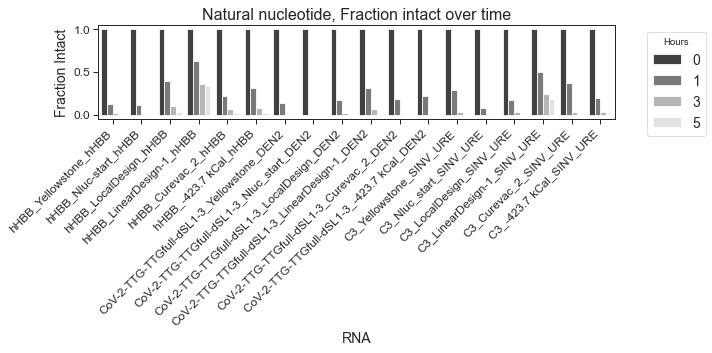

In [192]:
# map_df

plot_data = map_df[map_df['Nucleotide']=='natural'].sort_values(by='Sample', ascending=False)

figure(figsize=(10,5))
sns.barplot(data=plot_data, x='Sample',y='Fraction_intact', hue='Timepoint',
           palette='Greys_r')

legend(title='Hours', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
title('Natural nucleotide, Fraction intact over time')
xlabel('RNA')
ylabel('Fraction Intact')
xticks(rotation=45, ha='right')

tight_layout()
savefig(plot_dir+'barplot_FracInt_time_naturalRNA.png', dpi=300)

### comparing natural to modified nucleotides

<Figure size 720x1080 with 0 Axes>

Text(0.5, 1.0, 'Fraction Intact at 1 Hr, U vs. PSU')

Text(0.5, 0, '')

Text(0, 0.5, 'Fraction Intact')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

Text(0.5, 1.0, 'Fraction Intact at 3 Hr, U vs. PSU')

Text(0.5, 0, '')

Text(0, 0.5, 'Fraction Intact')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

Text(0.5, 1.0, 'Fraction Intact at 5 Hr, U vs. PSU')

Text(0.5, 0, 'RNA')

Text(0, 0.5, 'Fraction Intact')

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

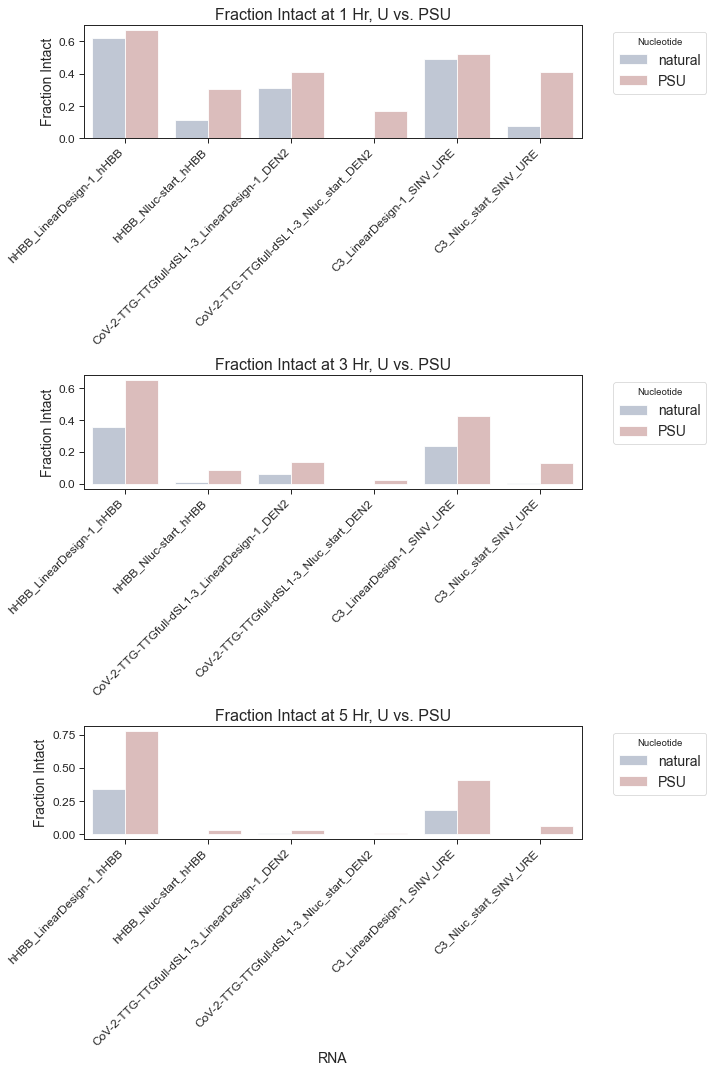

In [193]:
### let's take timepoint 2 (1 hr) as a benchmark, and also compare fraction intact at 5 hours
mod_samples = list(map_df[map_df['Nucleotide']=='PSU']['Sample'])

times = [1, 3, 5]

nrows = 3
ncolumns = 1

figure(figsize=(10,15))

for i, time in enumerate(times):
    subplot(nrows,ncolumns,i+1)
    
    plot_data = map_df[(map_df['Sample'].isin(mod_samples)) & (map_df['Timepoint']==time)]
    
    sns.barplot(data=plot_data, x='Sample',y='Fraction_intact', hue='Nucleotide',
               palette='vlag')

    legend(title='Nucleotide', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
    title('Fraction Intact at '+str(time)+' Hr, U vs. PSU')
    
    if i==2:
        xlabel('RNA')
    else:
        xlabel('')
    ylabel('Fraction Intact')
    xticks(rotation=45, ha='right')

    tight_layout()
savefig(plot_dir+'barplot_FracInt_times_PSU.png', dpi=300)

<Figure size 1440x2160 with 0 Axes>

(array([0.5, 1.5, 2.5, 3.5]), <a list of 4 Text major ticklabel objects>)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5]),
 <a list of 24 Text major ticklabel objects>)

Text(157.65312499999996, 0.5, '')

Text(0.5, 247.7, 'Hours')

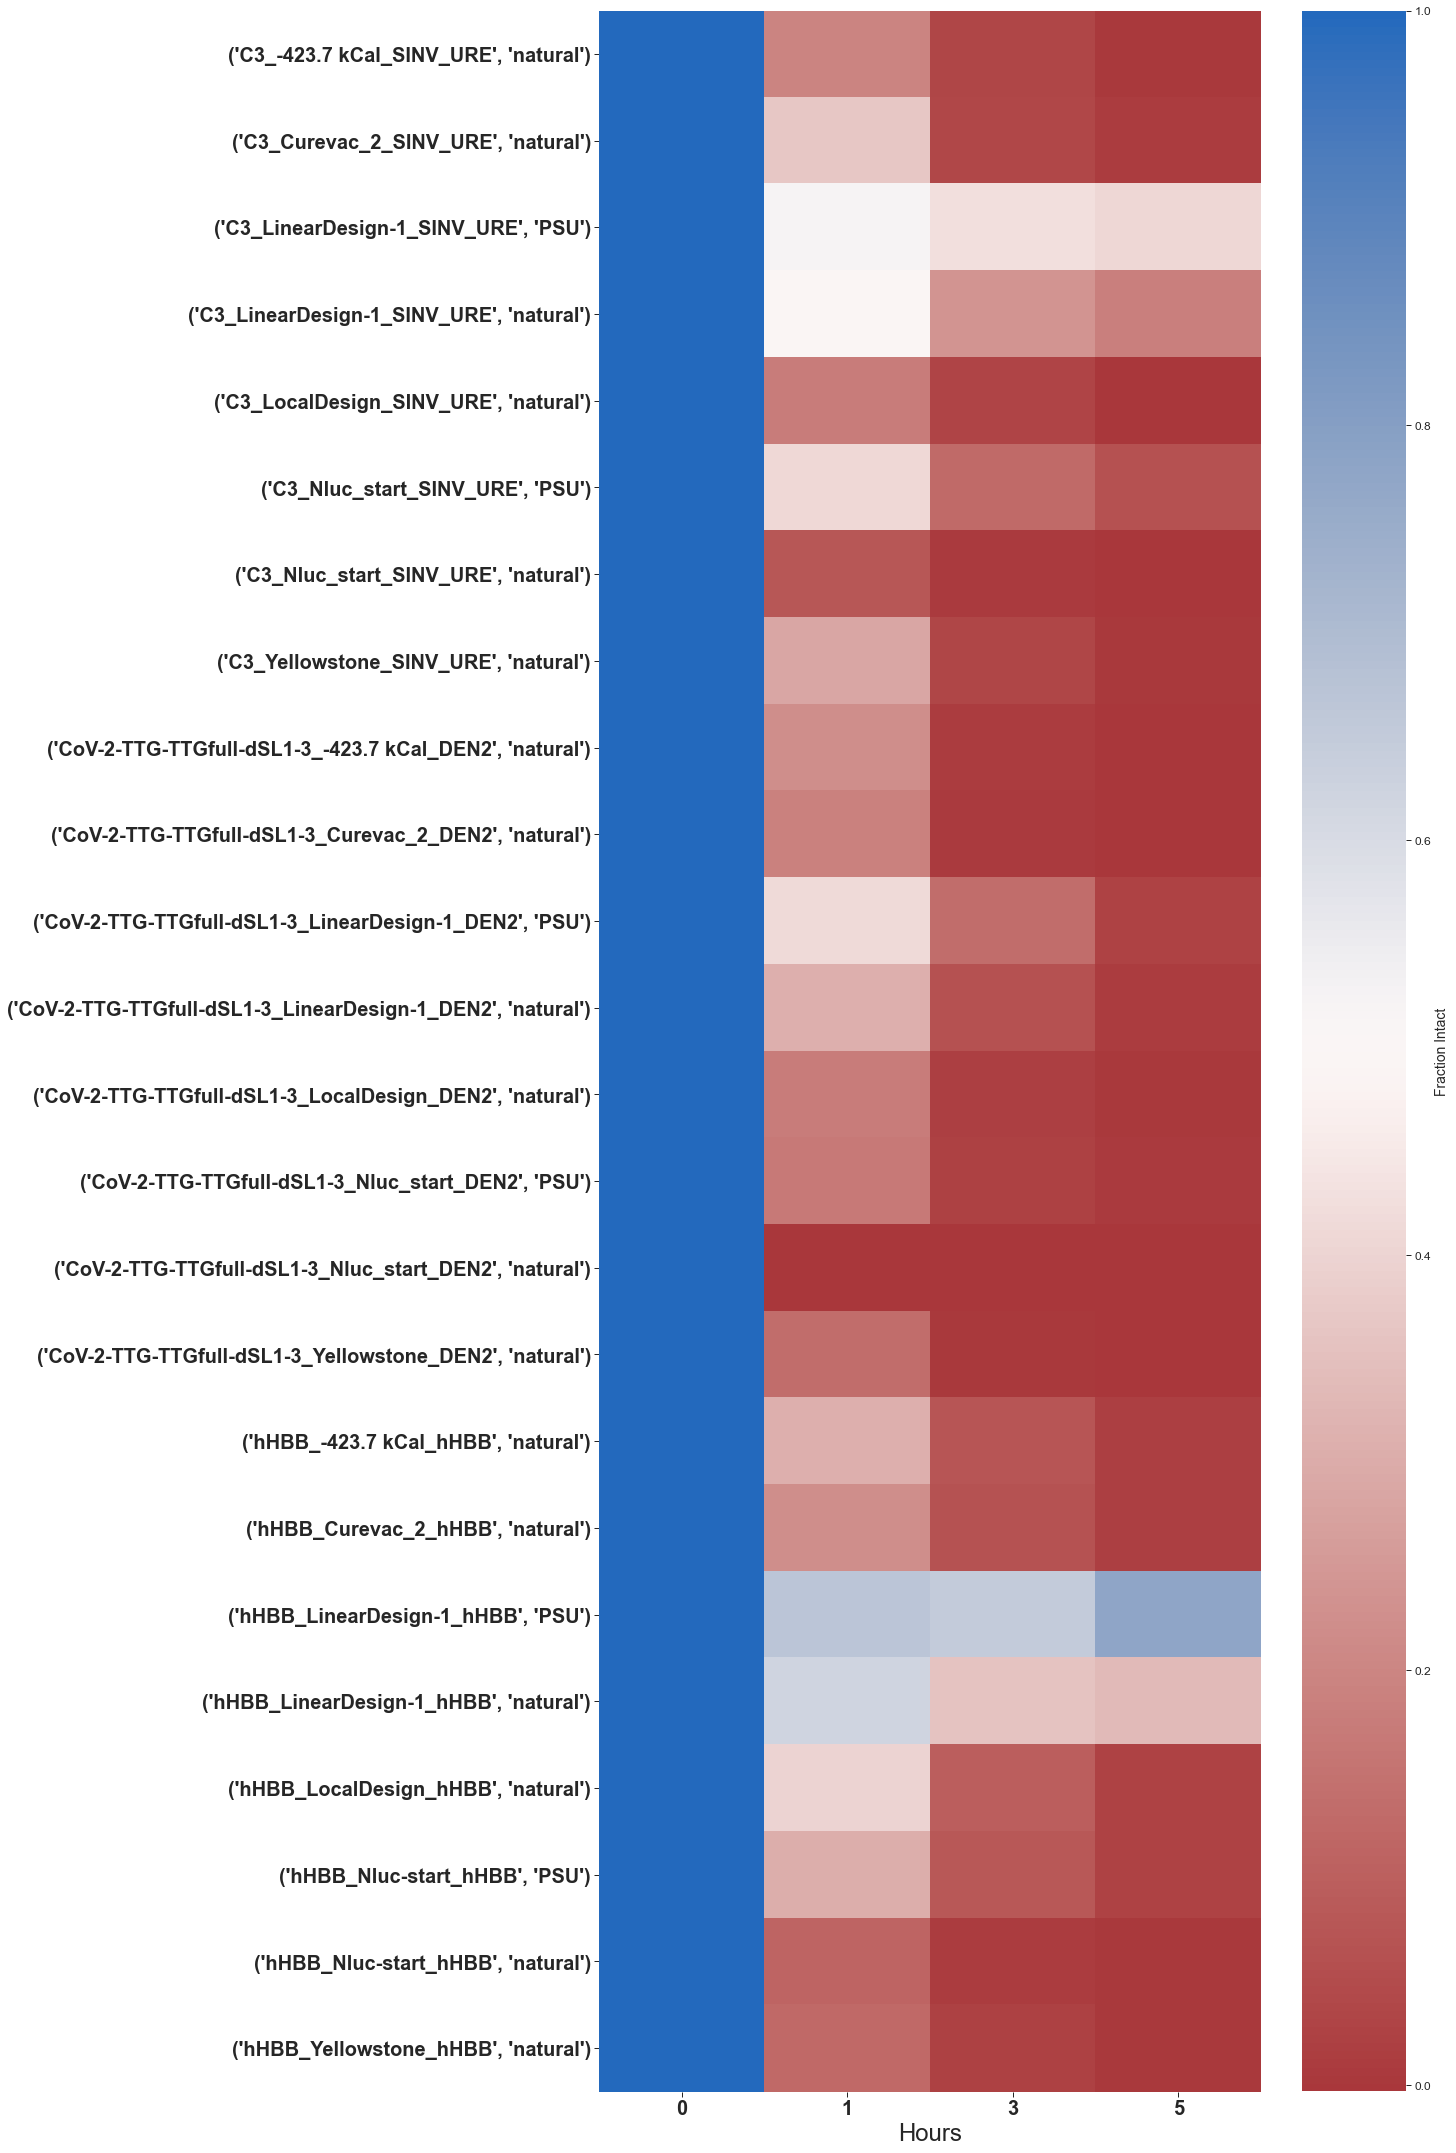

In [194]:
map_df['sample_nt'] = list(zip(map_df['Sample'], map_df['Nucleotide']))
melted_df = map_df.pivot(index='sample_nt', columns='Timepoint', values='Fraction_intact')
# melted_df

figure(figsize=(20,30))
sns.heatmap(data=melted_df, cmap='vlag_r',cbar_kws={'label': 'Fraction Intact'})
xticks(fontsize=20, fontweight='bold')
yticks(fontsize=20, fontweight='bold')
ylabel('')
xlabel('Hours', fontsize=24)
tight_layout()
# title('Fraction Intact over time', fontsize=30)

savefig(plot_dir+'heatmap_fracintact.png', dpi=300)

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'RNA')

Text(0, 0.5, 'kdeg (hr-1)')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

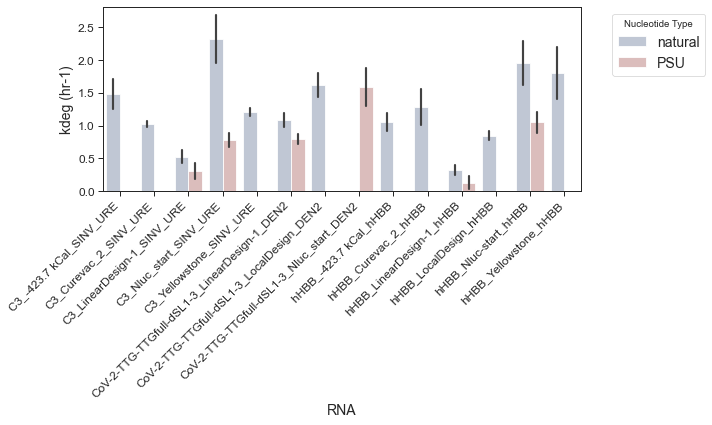

In [301]:
all_fits_df = pd.DataFrame.from_dict(all_fits, orient='index')
all_fits_df = all_fits_df.reset_index().rename({'index':'Sample'})
all_fits_df_long = pd.melt(all_fits_df, id_vars=['index'], value_vars=np.arange(1000))
all_fits_df_long['Sample'] = [str(sample[0]) for sample in all_fits_df_long['index']]
all_fits_df_long['Nucleotide'] = [str(sample[1]) for sample in all_fits_df_long['index']]
all_fits_df_long['kdeg'] = [float(x) for x in all_fits_df_long['value']]

kdeg_df_long = all_fits_df_long[['Sample', 'Nucleotide', 'kdeg']]


figure(figsize=(10,6))
sns.barplot(data=kdeg_df_long, x='Sample', y='kdeg', hue='Nucleotide', ci='sd', palette='vlag')
xlabel('RNA')
ylabel('kdeg (hr-1)')
legend(title='Nucleotide Type',loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=14)
xticks(ha='right', rotation=45)
tight_layout()
savefig(plot_dir+'kdeg_fits.png', dpi=300)


In [195]:
# fits_df = pd.DataFrame(sample_fits).T
# fits_df = fits_df.reset_index()

# fits_df.rename({'level_0': 'Sample', 'level_1': 'Nucleotide'})

# sns.barplot(data=fits_df, y='kdeg', x='level_0', hue='level_1')